In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import numpy as np
import pandas as pd
from numpy import linalg
import cvxopt
import cvxopt.solvers
import pylab as pl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

In [21]:
# Define gaussian kernel
def gaussian_kernel(x, y, sigma=1.75):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [22]:
class SVM(object):

    def __init__(self, kernel=gaussian_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        # Compute the Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        # construct P, q, A, b, G, h matrices for CVXOPT
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)
        if self.C is None:     # hard-margin SVM
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:              # soft-margin SVM
            G = cvxopt.matrix(np.vstack((np.diag(np.ones(n_samples) * -1), np.identity(n_samples))))
            h = cvxopt.matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        # Lagrange multipliers
        a = np.ravel(solution['x'])
        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5 # some small threshold
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))
    
        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)
        
    def project(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
        return y_predict + self.b
        
    def predict(self, X):
        return np.sign(self.project(X))           

In [23]:
def plot_margin(X1_train, X2_train, clf):
        def f(x, w, b, c=0):
            # given x, return y such that [x,y] in on the line w.x + b = c
            return (-w[0] * x - b + c) / w[1]

        pl.plot(X1_train[:,0], X1_train[:,1], "ro")
        pl.plot(X2_train[:,0], X2_train[:,1], "bo")
        pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

        # w.x + b = 0
        a0 = -4; a1 = f(a0, clf.w, clf.b)
        b0 = 4; b1 = f(b0, clf.w, clf.b)
        pl.plot([a0,b0], [a1,b1], "k")

        # w.x + b = 1
        a0 = -4; a1 = f(a0, clf.w, clf.b, 1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, 1)
        pl.plot([a0,b0], [a1,b1], "k--")

        # w.x + b = -1
        a0 = -4; a1 = f(a0, clf.w, clf.b, -1)
        b0 = 4; b1 = f(b0, clf.w, clf.b, -1)
        pl.plot([a0,b0], [a1,b1], "k--")

        pl.axis("tight")
        pl.show()

In [24]:
def plot_contour(X1_train, X2_train, clf):
  pl.plot(X1_train[:,0], X1_train[:,1], "ro")
  pl.plot(X2_train[:,0], X2_train[:,1], "bo")
  pl.scatter(clf.sv[:,0], clf.sv[:,1], s=100, c="g")

  X1, X2 = np.meshgrid(np.linspace(-6,6,50), np.linspace(-6,6,50))
  X = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])
  Z = clf.project(X).reshape(X1.shape)
  pl.contour(X1, X2, Z, [0.0], colors='k', linewidths=1, origin='lower')
  pl.contour(X1, X2, Z + 1, [0.0], colors='grey', linewidths=1, origin='lower')
  pl.contour(X1, X2, Z - 1, [0.0], colors='grey', linewidths=1, origin='lower')

  pl.axis("tight")
  pl.show()

In [25]:
df = pd.read_excel('/content/drive/MyDrive/Proj2DataSet.xlsx', header = None)
df.head()

,0,1,2
0,1.160947,3.316569,1.0
1,0.384876,2.260154,1.0
2,0.761007,4.373630,1.0
3,1.614981,4.262774,1.0
4,0.098600,3.659726,1.0


In [26]:
df.columns=['x1','x2','y']

def split_train(X1, y1, X2, y2):
    X1_train = X1[:80]
    y1_train = y1[:80]
    X2_train = X2[:80]
    y2_train = y2[:80]
    X_train = np.vstack((X1_train, X2_train))
    y_train = np.hstack((y1_train, y2_train))
    return X_train, y_train

def split_test(X1, y1, X2, y2):
    X1_test = X1[80:]
    y1_test = y1[80:]
    X2_test = X2[80:]
    y2_test = y2[80:]
    X_test = np.vstack((X1_test, X2_test))
    y_test = np.hstack((y1_test, y2_test))
    return X_test, y_test

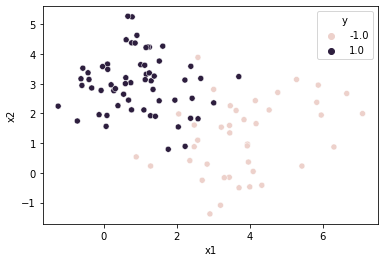

In [27]:
sns.scatterplot(data=df,x='x1',y='x2',hue='y')

In [28]:
X = df.drop('y',axis=1)
y = df['y']
x_train,  x_test,y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [29]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [33]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [30]:
x_train.shape,y_train.shape

((80, 2), (80,))

In [31]:
clf = SVM(C=10)
clf.fit(x_train, y_train)

     pcost       dcost       gap    pres   dres
 0:  6.1747e+01 -2.5940e+03  4e+03  2e-01  4e-15
 1:  5.9667e-02 -3.9762e+02  4e+02  1e-02  4e-15
 2: -7.0623e+01 -1.9900e+02  1e+02  3e-03  4e-15
 3: -9.7712e+01 -1.4614e+02  5e+01  7e-04  4e-15
 4: -1.0433e+02 -1.3252e+02  3e+01  3e-04  4e-15
 5: -1.1352e+02 -1.1938e+02  6e+00  2e-05  4e-15
 6: -1.1558e+02 -1.1664e+02  1e+00  1e-06  5e-15
 7: -1.1603e+02 -1.1605e+02  3e-02  4e-09  5e-15
 8: -1.1604e+02 -1.1604e+02  3e-04  4e-11  5e-15
 9: -1.1604e+02 -1.1604e+02  3e-06  4e-13  5e-15
Optimal solution found.
17 support vectors out of 80 points


18 out of 20 predictions correct


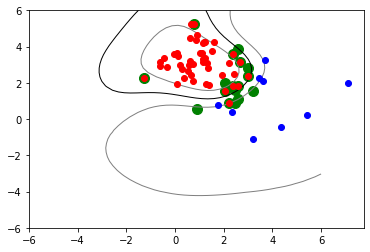

In [34]:
y_predict = clf.predict(x_test)
correct = np.sum(y_predict == y_test)
print("%d out of %d predictions correct" % (correct, len(y_predict)))

plot_contour(x_train[y_train==1], x_test[y_predict==-1], clf)